In [1]:
# Setting up google drive 
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#import sys
#sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [2]:
import my_utils as mu
import torch
from torch import nn
from torch.nn import functional as F


# The Task

* Our **Task** for this week is to implement ResNet, the most widely-used Deep Learning architecture to date!
* The Learning Outcome: Hands-on application of PyTorch's API for creating Advanced CNNs.



## Task 1: Implement the ResNet block

* ResNet-18 uses extensively the so-called ResNet block which has a skip connection.
* The graphical illustration of the ResNet block is shown below.
* Your ResNet block should accept `input_channels` as input, and produce `output_channels` as ouput.
* As shown below, both Conv. layers within a ResNet block should have a kernel size $3 \times 3$, and padding 1. The first Conv. layer should also accept a `stride` parameter which can be used to reduced spatial resolution. For example, if `stride=2`, the resolution will be halved. 
* The right block is used when the number of channels in the input is not the same as the number of channels in the output.
    * An $1 \times 1$ conv. layer is used to make them equal.     
* **Your task** is to create a single class called `Residual_block` that should handle both cases. 


![Left: regular ResNet block; Right: ResNet block with 1x1 convolution.](https://drive.google.com/uc?export=view&id=1oKGT5iabWYLT7pUlMZOCX4-Drr3IttVZ)


In [3]:
class Residual_block(nn.Module):  
    def __init__(self, input_channels, output_channels, use_1x1conv=False, strides=1):
        super(Residual_block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
            
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) 
        out = self.bn2(self.conv2(out))
        if self.conv3:
            x = self.conv3(x)
        out = out + x
        return F.relu(out)

In [4]:
res= Residual_block(3,16,use_1x1conv=True)

## Task 2: Implement ResNet Macro-Block

* ResNet-18 uses modules also called Macro-Blocks each of which contains 2 ResNet blocks. 

* In the first ResNet block within each Macro-Block, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

* In the second ResNet block, the number of channels remains the same.
* **Your task** is to implement a class called `Resnet_macro_block`. Your Macro-Block should accept `input_channels` as input, and produce `output_channels` as ouput.

In [5]:
class Resnet_macro_block(nn.Module):
    def __init__(self, input_channels, output_channels, num_residuals, first_block=False):
        super(Resnet_macro_block, self).__init__()
        self.num_residuals = num_residuals
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.add_module('conv{0}'.format(i), 
                                Residual_block(input_channels, output_channels, use_1x1conv=True, strides=2))
            else:
                self.add_module('conv{0}'.format(i), 
                                Residual_block(output_channels, output_channels))
    def forward(self, x):
        out = x
        for i in range(self.num_residuals):
            out = self._modules['conv{0}'.format(i)](out)
        return out 

## Task 3: Implement ResNet-18 Architecture


* We will consider here the implementation of a slightly modified version of ResNet-18, appropriate for the input resolution of $32 \times 32$.
* ResNet-18 has 1 stem and 4 macro-modules followed by 1 linear (FC) layer. 
* Stem = simple processing unit with:
    * 1 standard conv. layer with kernel $3\times 3$, stride 1, and number of output channels 64. It processes features at resolution 32 (input resolution).
    * A Batch-Norm layer.
    * A Relu.
* Each macro-module processes features in a different resolution. 
     * Resolutions used are: 16, 8, 4, 2
* As mentioned above, the macro-modules are composed of the so-called ResNet blocks.
    * In ResNet-18, there are 2 ResNet blocks per macro-module.
* Each ResNet (Residual) block consists of 2 convolutions with skip connections.
* In total $1 + 4\times2\times2 + 1=18$ layers.
* **Your task** is to implement a class called `Resnet18`. A skeleton can be found below where the stem and the FC connected layer are provided.

In [6]:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.stem = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU())
        self.b2 = Resnet_macro_block(64, 64, 2)
        self.b3 = Resnet_macro_block(64, 128, 2)
        self.b4 = Resnet_macro_block(128, 256, 2)
        self.b5 = Resnet_macro_block(256, 512, 2)
        self.last = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10))
        
    def forward(self, x):
        out = self.stem(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.last(out)
        return out

In [7]:
# Test your implementation here!
resnet18 = Resnet18()
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size, resize=32)
train_iter2 = iter(train_iter)
x = next(train_iter2)
print(x[0].size())
y_hat = resnet18(x[0])

torch.Size([256, 1, 32, 32])


In [8]:
# Training a ResNet18 on Fashion Mnist
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=lr)

## Switch to a GPU with Colab 

* Google colab offers free GPU training. Some of the available GPU types are Nvidia K80s, T4s, P4s and P100s. You can choose to train on a CPU or GPU but you can not choose what type of gpu you will be connected to at any given time.

* To switch to GPU training you can either do: 
    1. **Edit** ==> **Notebook settings** ==> **Hardware Accelerator (GPU)** ==> **Save** , or
    2. **Runtime** ==> **Change runtime type** ==> **Hardware Accelerator (GPU)** ==> **Save**

* If you choose to train on a GPU you will have to restart colab. To do so, select **Runtime** and then choose **Restart and run all**.

* Cast your model, input and labels to the GPU (done below)

In [9]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.077, train acc 0.971, test acc 0.905
76.7 examples/sec on cpu


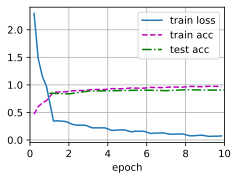

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(resnet18, train_iter, test_iter, loss, num_epochs, optimizer, device)